# **02 - Naive Baseline Models**

Before building sophisticated models (GARCH, LSTM, Transformer), we must establish how good simple approaches can be. This provides insight into whether or not increasingly complex models are justified.

## Importance of Baselines

- **In machine learning:** Complex models often barely beat naive baselines    
- **In volatility forecasting:** High persistence makes "tomorrow = today" quite powerful    
- **For this project:** These baselines set the bar that GARCH/LSTM/Transformer must clear  

## Baselines Tested

- **Persistence** - Tomorrow = Today (leverages autocorrelation)
- **Rolling means** - Smooth recent history (5, 10, 21 days)
- **Global mean** - Historical average (tests mean reversion)

## Key Finding Preview

Persistence achieves RMSE = 0.000698, which is very low.

This is because `rv_21` is strongly autocorrelated (ACF = 0.99 from `NB01`), which means volatility changes slowly. Simple persistence uses this very fact to provide extremely close predictions.



## **Imports and Configuration**

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

In [2]:
# Paths
PROCESSED_DIR = Path("../data/processed")
RESULTS_DIR = Path("../results/baselines/")
FIG_DIR = Path("../results/figures/baselines")

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

## **Load Data**

In [3]:
df = pd.read_csv(PROCESSED_DIR / "modeling_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values("Date").reset_index(drop=True)

print(df.head(), "\n")
print(df.tail(), "\n")
print(df.isna().sum())

target_col = "rv_21"

        Date         Open         High          Low        Close    Adj Close  \
0 2000-02-02  1409.280029  1420.609985  1403.489990  1409.119995  1409.119995   
1 2000-02-03  1409.119995  1425.780029  1398.520020  1424.969971  1424.969971   
2 2000-02-04  1424.969971  1435.910034  1420.630005  1424.369995  1424.369995   
3 2000-02-07  1424.369995  1427.150024  1413.329956  1424.239990  1424.239990   
4 2000-02-08  1424.239990  1441.829956  1424.239990  1441.719971  1441.719971   

       Volume  log_return     rv_21  
0  1038600000   -0.000114  0.016190  
1  1146500000    0.011185  0.013915  
2  1045100000   -0.000421  0.013915  
3   918100000   -0.000091  0.013916  
4  1047700000    0.012198  0.012880   

           Date         Open         High          Low        Close  \
6496 2025-12-01  6812.299805  6843.649902  6799.939941  6812.629883   
6497 2025-12-02  6830.959961  6851.549805  6806.709961  6829.370117   
6498 2025-12-03  6815.290039  6862.419922  6810.430176  6849.720215   

## **Train-Test Split**

**Split strategy:** 80/20 chronological (no shuffling)

**Reasons for preserving chronology:**
- Time series have temporal dependencies which are broken by shuffling
- Models must forecast the future, not interpolate the past
- Simulates real-world deployment i.e. train on history, predict tomorrow

The test set includes the post-COVID recovery period (starting Oct 2020), testing whether baselines can adapt after the March 2020 volatility spike that occurred in 
the training set.

**Note:** The COVID volatility spike itself (Feb-Mar 2020) is in the training data. This is intentional as models learn from crisis periods and are evaluated on subsequent behavior.

In [4]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train period: ", train["Date"].min(), "to", train["Date"].max())
print("Test period: ", test["Date"].min(), "to", test["Date"].max())
print("Test observations:", len(test))
print("Years of test data:", round(len(test) / 252, 2))

y_train = train[target_col].values
y_test = test[target_col].values
dates_test = test["Date"].values

Train period:  2000-02-02 00:00:00 to 2020-10-01 00:00:00
Test period:  2020-10-02 00:00:00 to 2025-12-05 00:00:00
Test observations: 1301
Years of test data: 5.16


## **Baseline Models**

We now construct the following baselines-
* Persistence: forecast tomorrow as today.
* Rolling mean with window 5.
* Rolling mean with window 10.
* Rolling mean with window 21.
* Global mean of the training set.

These baselines are simple but informative. They show how much structure an advanced model must capture to outperform naive strategies.

### **Persistence Model**

**Forecast rule:** `rv_21(t+1) = rv_21(t)`

We know that `rv_21` has strong autocorrelation. This means:
- If volatility is high today, it's likely high tomorrow
- Slow-moving series means yesterday is informative

In [5]:
train["persistence"] = train[target_col].shift(1)
test["persistence"] = test[target_col].shift(1)

# First test forecast uses the last training value
test.loc[test.index[0],"persistence"] = train[target_col].iloc[-1]

### **Rolling Mean Baselines**

**Forecast rule:** Forecast = average of last N observations

**Window choices:**
- **5 days:** ~1 trading week (responsive to recent changes)
- **10 days:** ~2 trading weeks (balanced)
- **21 days:** ~1 trading month (matches `rv_21` construction)

We use the final training rolling mean as a constant forecast across the entire test set. This is leak-free but static, so it doesn't adapt to volatility regime changes.

This is intentionally simplistic. Walk-forward rolling means (updating with each test observation) would perform better but will complicate direct comparison with GARCH/neural models which make true out-of-sample forecasts.


In [6]:
for w in [5, 10, 21]:
    roll_name = f"roll_mean_{w}"
    train[roll_name] = train[target_col].rolling(w).mean()
    
    last_roll_value = train[roll_name].iloc[-1]
    test[roll_name] = last_roll_value


### **Global Mean Baseline**

**Forecast rule:** `rv_21(t+1) = mean(training rv_21)`

**What this tests:**
- **Assumption:** Volatility always reverts to its long-run average
- **Forecast:** Constant (~1% volatility) regardless of current level

**When this works well:**
- Stable periods (volatility near historical average)
- Long forecast horizons (short-term noise averages out)

**When this fails:**
- Regime shifts (2008 crisis, COVID spike)
- Persistent deviations from mean

From `NB01`, we know volatility is mean-reverting (decays after spikes) but also highly autocorrelated (decays slowly). Global mean assumes instant reversion to the long-run average, ignoring the autocorrelation that makes persistence powerful.

In [7]:
global_mean = y_train.mean()
test["global_mean"] = global_mean

## **Evaluation Metrics**

We compute RMSE and MAE for each baseline. These metrics provide complementary views of forecast performance.

In [8]:
results = []

baseline_cols = ["persistence", "roll_mean_5", "roll_mean_10", "roll_mean_21", "global_mean"]

for col in baseline_cols:
    preds = test[col].values
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    results.append({
        "model": col,
        "rmse": rmse,
        "mae": mae
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

best_model = metrics_df.loc[metrics_df['rmse'].idxmin(), 'model']
best_rmse = metrics_df['rmse'].min()

print("\n=== Baseline Summary ===\n")
print(f"Lowest RMSE comes from: {best_model}")
print(f"RMSE value: {best_rmse:.6f}")


          model      rmse       mae
0   persistence  0.000698  0.000351
1   roll_mean_5  0.007216  0.006536
2  roll_mean_10  0.006772  0.006086
3  roll_mean_21  0.005747  0.005011
4   global_mean  0.004536  0.003477

=== Baseline Summary ===

Lowest RMSE comes from: persistence
RMSE value: 0.000698


### **Interpretation**

**Performance Ranking:**
1. **Persistence:** RMSE = 0.000698 (best)
2. **Global mean:** RMSE = 0.004536
3. **Rolling mean (21):** RMSE = 0.005747
4. **Rolling mean (10):** RMSE = 0.006772
5. **Rolling mean (5):** RMSE = 0.007216 (worst)

### Key Insights:

**Persistence dominates**
- Better than all other baselines by a large margin
- Confirms `NB01` finding: `rv_21` has strong autocorrelation (ACF = 0.99), making persistence extremely effective
- This is the bar GARCH/LSTM/Transformer must clear

**Global mean outperforms rolling means**
- Rolling means are too smooth (lag reality) while global mean captures the right average level
- Since volatility itself has slow decay but can jump quickly, static rolling means fail to adapt to sudden regime changes.
- Shows that *smoothing ≠ better forecasting* for volatile series

**Shorter windows hurt more**
- 5-day rolling worst (RMSE = 0.007216)
- 21-day rolling better (RMSE = 0.005747)
- This is because short windows track noise, not structure, while long windows stay closer to stable long-run volatility levels.

**Absolute errors are small**
- All RMSEs < 0.008 (`rv_21` typically ranges between 0.5% - 3%)
- However, relative differences are huge (10× between best and worst)

## **Plots**

### **Baseline Forecasts**

A visual comparison is useful to understand how each baseline behaves across the test period.

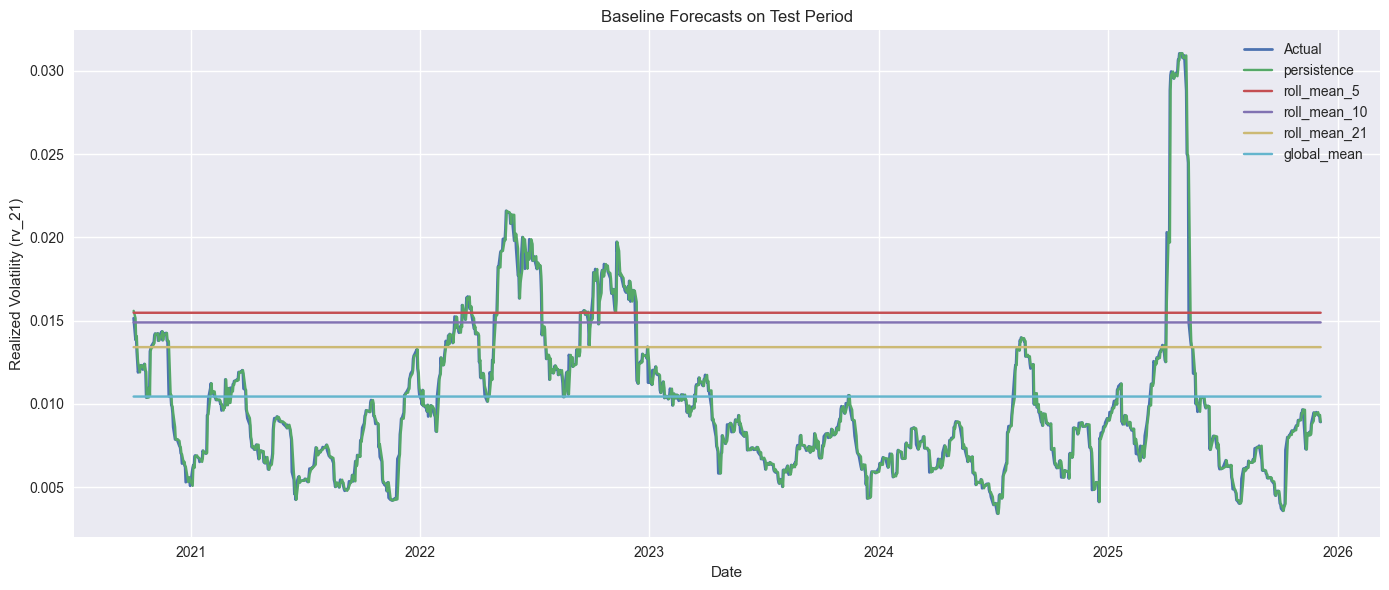

In [9]:
plt.figure(figsize=(14, 6))

plt.plot(test["Date"], y_test, label="Actual", linewidth=2)

for col in baseline_cols:
    plt.plot(test["Date"], test[col], label=col)

plt.title("Baseline Forecasts on Test Period")
plt.xlabel("Date")
plt.ylabel("Realized Volatility (rv_21)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_forecasts.png", dpi=200)
plt.show()


The rolling mean forecasts appear as flat horizontal lines. This is expected, since we freeze the rolling mean after training, so we avoid peeking at future volatility levels.

### **Forecast Errors Over Time**

Since rolling means are constant, plotting forecasts directly isn't informative. Plotting forecast errors might give more insights.

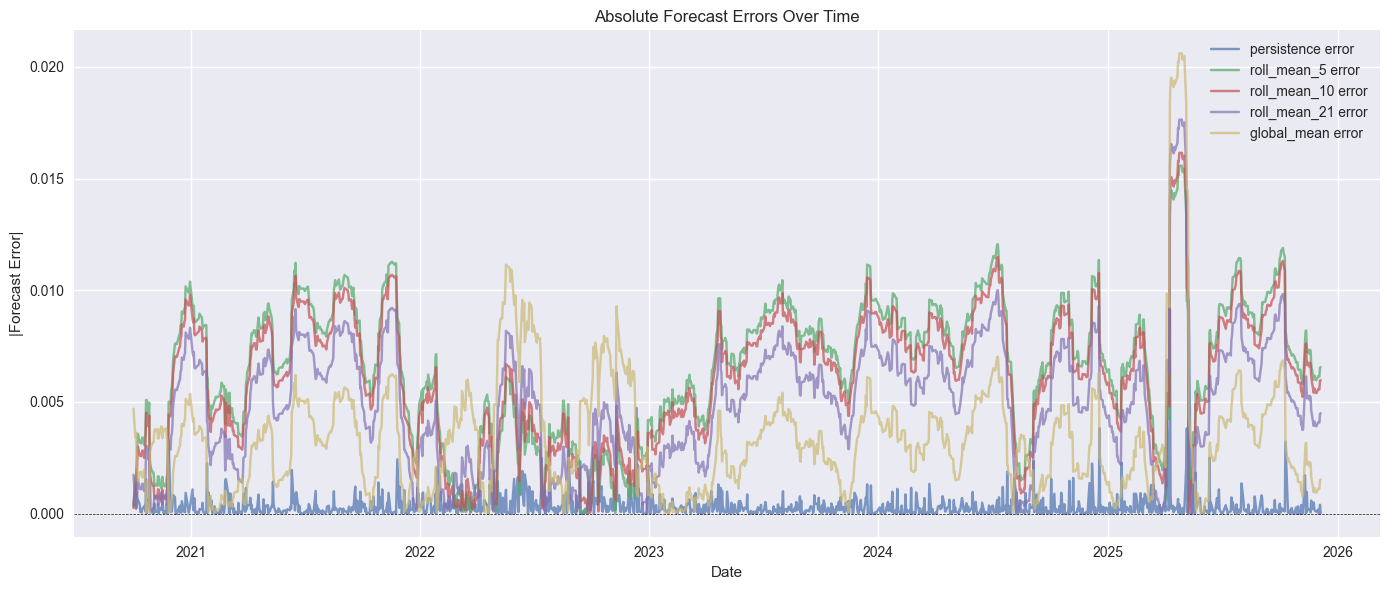

In [10]:
plt.figure(figsize=(14, 6))

# Plot absolute errors
for col in baseline_cols:
    errors = np.abs(test[col] - y_test)
    plt.plot(test["Date"], errors, label=f"{col} error", alpha=0.7)

plt.title("Absolute Forecast Errors Over Time")
plt.xlabel("Date")
plt.ylabel("|Forecast Error|")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_errors.png", dpi=200)
plt.show()

**Visual observations:**

- Persistence errors are small and stable (tracks volatility well)
- Rolling mean errors spike during volatility regime changes (static forecasts can't adapt)
- Global mean errors moderate (right on average, wrong in detail)

## **Save Outputs**
We save both the forecasts and the evaluation metrics for downstream comparison in later notebooks.

In [11]:
# Save predictions
test_out = test[["Date", target_col] + baseline_cols]
test_out.to_csv(RESULTS_DIR / "baseline_forecasts.csv", index=False)

# Save metrics
metrics_df.to_csv(RESULTS_DIR / "baseline_metrics.csv", index=False)

test_out.head(), metrics_df


(           Date     rv_21  persistence  roll_mean_5  roll_mean_10  \
 5200 2020-10-02  0.015151     0.015589     0.015475      0.014895   
 5201 2020-10-05  0.013848     0.015151     0.015475      0.014895   
 5202 2020-10-06  0.014067     0.013848     0.015475      0.014895   
 5203 2020-10-07  0.013131     0.014067     0.015475      0.014895   
 5204 2020-10-08  0.012524     0.013131     0.015475      0.014895   
 
       roll_mean_21  global_mean  
 5200      0.013412     0.010445  
 5201      0.013412     0.010445  
 5202      0.013412     0.010445  
 5203      0.013412     0.010445  
 5204      0.013412     0.010445  ,
           model      rmse       mae
 0   persistence  0.000698  0.000351
 1   roll_mean_5  0.007216  0.006536
 2  roll_mean_10  0.006772  0.006086
 3  roll_mean_21  0.005747  0.005011
 4   global_mean  0.004536  0.003477)

## **Summary**

Best baseline: Persistence (RMSE = 0.000698)  
Worst baseline: 5-day rolling mean (RMSE = 0.007216)  
Performance range: approximately 10× difference between best and worst

### **Key Insight** 

Simple persistence leverages `rv_21`'s strong autocorrelation to achieve remarkably low error. This creates a high bar for sophisticated models.

### **Other Insights**

**Autocorrelation matters more than complexity**
- Persistence (zero parameters) beats all averaging methods
- Confirms EDA finding: volatility changes slowly

**Smoothing can worsen performance**
- Rolling means lag reality
- Global mean is relatively competitive (right average, wrong timing)

**The modeling challenge ahead**
- GARCH/LSTM/Transformer must beat RMSE = 0.000698
- Given strong persistence, marginal improvements may be the best possible
